<a href="https://colab.research.google.com/github/chauhanneha16/Audio_Spoofing/blob/main/antispoofing_transfoer%2Bmfcc%2Bcentroid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d awsaf49/asvpoof-2019-dataset

Dataset URL: https://www.kaggle.com/datasets/awsaf49/asvpoof-2019-dataset
License(s): ODC Attribution License (ODC-By)
100% 23.6G/23.6G [22:07<00:00, 22.7MB/s]
100% 23.6G/23.6G [22:07<00:00, 19.1MB/s]


In [ ]:
%env KAGGLE_CONFIG_DIR=/root/.kaggle/

env: KAGGLE_CONFIG_DIR=/root/.kaggle/


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/kaggle/DS_10283_3336/LA.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Function to extract centroid feature
def extract_centroid(audio, sr):
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)
    return centroid.T

# Define a custom dataset class
class AudioDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = {'X': self.X[idx], 'y': self.y[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
# Define a transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_dim, output_dim, d_model=128, num_heads=4, num_layers=3):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.fc(x[:, -1, :])  # Take only the output of the last time step
        return x


In [ ]:
# Load data
DATASET_PATH = "/content/LA/ASVspoof2019_LA_eval/flac"
LABEL_FILE_PATH = "/content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
SAMPLE_RATE = 22050
DURATION = 3
N_MELS = 128
MAX_TIME_STEPS = 109

In [ ]:
import os
import numpy as np
import librosa

def extract_features(audio_file_path, sample_rate, duration, n_mfcc, n_mels, max_time_steps):
    # Load audio file using librosa
    audio, _ = librosa.load(audio_file_path, sr=sample_rate, duration=duration)

    # Extract MFCCs using librosa
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)

    # Extract centroid feature
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sample_rate)

    # Ensure all features have the same width (time steps)
    if mfcc.shape[1] < max_time_steps:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_time_steps - mfcc.shape[1])), mode='constant')
        centroid = np.pad(centroid, ((0, 0), (0, max_time_steps - centroid.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_time_steps]
        centroid = centroid[:, :max_time_steps]

    # Combine MFCCs and centroid feature
    features = np.concatenate((mfcc, centroid), axis=0)

    return features

# Load data
DATASET_PATH = "/content/LA/ASVspoof2019_LA_eval/flac"
LABEL_FILE_PATH = "/content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
SAMPLE_RATE = 22050
DURATION = 3
N_MFCC = 13  # Number of MFCC coefficients
N_MELS = 128
MAX_TIME_STEPS = 109

labels = {}
with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Extract features
    features = extract_features(file_path, SAMPLE_RATE, DURATION, N_MFCC, N_MELS, MAX_TIME_STEPS)

    X.append(features)
    y.append(label)


In [ ]:
X = np.array(X)
y = np.array(y)

X,y

(array([[[-2.28439468e+02, -1.29143097e+02, -8.76759491e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.27975998e+01,  9.36111298e+01,  1.28975037e+02, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [-8.61375504e+01, -1.03599777e+02, -9.20949707e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [-6.74275339e-01, -8.68760395e+00, -2.06568165e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 8.87236595e-01, -1.76919138e+00, -1.14585285e+01, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 2.45355799e+03,  2.50253298e+03,  1.86089524e+03, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],
 
        [[-5.73458252e+02, -3.53071045e+02, -2.19594818e+02, ...,
          -2.97506470e+02, -2.53453323e+02, -2.45421600e+02],
         [ 5.86279945e+01,  1.42457275e+02,  1.68297852e+02, ...,
           1.09984222

In [ ]:

# Define paths and parameters
DATASET_PATH = "/content/LA/ASVspoof2019_LA_eval/flac"
LABEL_FILE_PATH = "/content/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.eval.trl.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MELS = 128  # Number of Mel frequency bins

In [ ]:

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
y_encoded = to_categorical(y, num_classes=2)


split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]


# Define test set from remaining data
X_test, y_test = X[split_index:], y_encoded[split_index:]

In [ ]:
input_shape = (X_train.shape[1], X_train.shape[2])  # Input shape for Transformer (time steps, features)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense

# Define Transformer model architecture
input_shape = (X_train.shape[1], X_train.shape[2])  # Input shape for Transformer (time steps, features)
num_classes = NUM_CLASSES

# Input layer
inputs = Input(shape=input_shape)

# Positional encoding
position_embeddings = Embedding(input_shape[0], input_shape[1])(tf.range(input_shape[0]))
x = inputs + position_embeddings

# Transformer layers
num_heads = 8
ff_dim = 64
num_layers = 4
embedding_dim = 32

for _ in range(num_layers):
    # Multi-head self-attention
    x = LayerNormalization()(x)
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
    x = x + attention_output

  # Feed-forward layer
    x = LayerNormalization()(x)
    x_ff = Dense(units=ff_dim, activation='relu')(x)
    x_ff = Dropout(0.1)(x_ff)
    x_ff = Dense(units=109, activation='relu')(x_ff)
    x_ff = Dropout(0.1)(x_ff)
    x = x + x_ff

# Global Average Pooling
x = GlobalAveragePooling1D()(x)

# Output layer
outputs = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 14, 109)]            0         []                            
                                                                                                  
 tf.__operators__.add_9 (TF  (None, 14, 109)              0         ['input_2[0][0]']             
 OpLambda)                                                                                        
                                                                                                  
 layer_normalization_8 (Lay  (None, 14, 109)              218       ['tf.__operators__.add_9[0][0]
 erNormalization)                                                   ']                            
                                                                                            

Epoch 1/10
1425/1425 [==============================] - 209s 138ms/step - loss: 0.2002 - accuracy: 0.9020 - val_loss: 0.1731 - val_accuracy: 0.9163
Epoch 2/10
1425/1425 [==============================] - 193s 136ms/step - loss: 0.1761 - accuracy: 0.9103 - val_loss: 0.1808 - val_accuracy: 0.9080
Epoch 3/10
1425/1425 [==============================] - 203s 142ms/step - loss: 0.1820 - accuracy: 0.9072 - val_loss: 0.1804 - val_accuracy: 0.9103
Epoch 4/10
1425/1425 [==============================] - 199s 139ms/step - loss: 0.1932 - accuracy: 0.8998 - val_loss: 0.1770 - val_accuracy: 0.9153
Epoch 5/10
1425/1425 [==============================] - 197s 138ms/step - loss: 0.1853 - accuracy: 0.9027 - val_loss: 0.1789 - val_accuracy: 0.9072
Epoch 6/10
1425/1425 [==============================] - 188s 132ms/step - loss: 0.1836 - accuracy: 0.9050 - val_loss: 0.1795 - val_accuracy: 0.9060
Epoch 7/10
1425/1425 [==============================] - 194s 136ms/step - loss: 0.1887 - accuracy: 0.9018 - val_

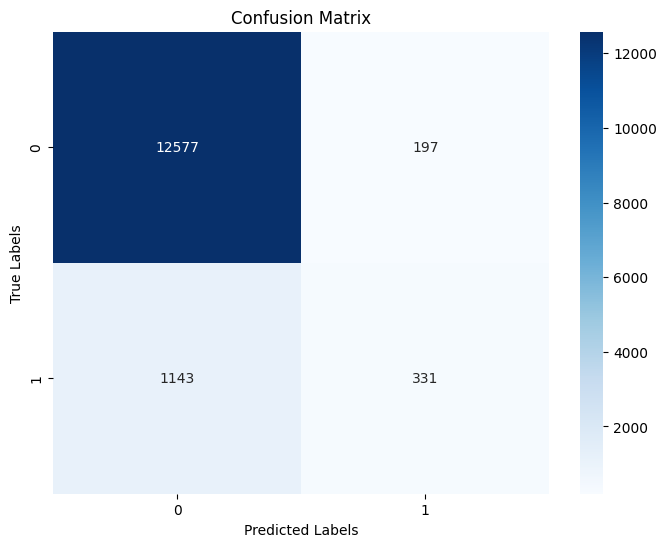

In [ ]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)
# Print the number of samples for training and testing
print("Number of training samples:", X_train.shape[0])
print("Number of testing samples:", X_test.shape[0])


# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
# Force layer normalization to run on CPU
with tf.device('/CPU:0'):
    y_pred = model.predict(X_test)

y_pred_classes = np.argmax(y_pred, axis=1)



# Compute confusion matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()





In [ ]:
import tensorflow as tf

# Save the model in native Keras format
model.save("audio_classifier.keras")